# Decision Tree Forecasting for Financial Time Series

This notebook demonstrates the application of machine learning techniques, specifically Decision Tree Regressors, for forecasting financial time series data. The workflow encompasses:

- **Data acquisition and preparation**: Fetching Google stock data with proper handling of business days and holidays
- **Exploratory data analysis**: Statistical characterization and visualization of price movements
- **Stationarity analysis**: Comprehensive testing (ADF, KPSS, Jarque-Bera) and transformation to log returns
- **Model development**: Implementing both traditional ARMA and ML-based forecasting approaches
- **Hyperparameter optimization**: Systematic grid search across lags and tree parameters
- **Model validation**: Backtesting with rolling window cross-validation and performance comparison

The analysis follows best practices in financial forecasting, including proper handling of non-trading days, comparison with statistical benchmarks (ARIMA), and rigorous out-of-sample testing to ensure model generalizability.

## Environment Setup and Library Imports

Loading all necessary libraries for data manipulation, statistical testing, machine learning, time series analysis, and visualization.

In [557]:
# --- Core Python and numerical computing ---
import os
import math
import numpy as np
import pandas as pd

# --- Financial data retrieval ---
import yfinance as yf

# --- Visualization libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# --- Machine learning frameworks ---
import sklearn.tree
import sklearn.metrics

# --- Specialized forecasting library ---
import skforecast.model_selection
import skforecast.preprocessing
import skforecast.recursive
import skforecast.sarimax

# --- Statistical analysis ---
import scipy.stats
import scipy.optimize

# --- Time series analysis and ARIMA modeling ---
import statsmodels.tsa
import statsmodels.graphics
from statsmodels.tsa.arima.model import ARIMA

# --- Dealing with the warnings ---
import warnings
warnings.filterwarnings(action='ignore')

## Data Acquisition and Initial Exploration

Fetching 5 years of Google (GOOG) stock price history with proper handling of business days and holidays. The data is re-indexed to business day frequency and forward-filled to handle public holidays appropriately.

In [558]:
# Fetch Google stock data and handle business days properly
# asfreq('B') creates a regular business day index
# ffill() forward-fills prices for public holidays (market closed, price unchanged)
google = yf.Ticker("GOOG")
google = google.history("5y").asfreq("B").ffill()

In [559]:
# Quick inspection of dataset structure: first and last 5 observations
# Verify date range and data consistency
pd.concat([google.head(), google.tail()])

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-16 00:00:00-05:00,87.982904,89.342102,87.783766,88.463615,24936000.0,0.0,0.0
2020-11-17 00:00:00-05:00,88.243145,88.643406,87.749522,87.905952,22942000.0,0.0,0.0
2020-11-18 00:00:00-05:00,87.661599,88.070802,86.713589,86.745369,23470000.0,0.0,0.0
2020-11-19 00:00:00-05:00,86.328229,87.878124,86.259948,87.596550,24998000.0,0.0,0.0
2020-11-20 00:00:00-05:00,87.660619,88.097131,86.501058,86.517441,46270000.0,0.0,0.0
2025-11-07 00:00:00-05:00,284.209991,284.500000,275.739990,279.700012,21991100.0,0.0,0.0
2025-11-10 00:00:00-05:00,285.265015,291.459991,283.540009,290.589996,19508200.0,0.0,0.0
2025-11-11 00:00:00-05:00,288.200012,292.339996,287.880005,291.739990,14156700.0,0.0,0.0
2025-11-12 00:00:00-05:00,292.084991,292.359985,284.380005,287.429993,16998800.0,0.0,0.0


In [560]:
# Comprehensive dataset summary
# Display data types, missing values, temporal span, and descriptive statistics
print(
    google.info(),
    google.shape,
    (google.index.max() - google.index.min()),
    sep = "\n\n"
)

google.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1304 entries, 2020-11-16 00:00:00-05:00 to 2025-11-13 00:00:00-05:00
Freq: B
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1304 non-null   float64
 1   High          1304 non-null   float64
 2   Low           1304 non-null   float64
 3   Close         1304 non-null   float64
 4   Volume        1304 non-null   float64
 5   Dividends     1304 non-null   float64
 6   Stock Splits  1304 non-null   float64
dtypes: float64(7)
memory usage: 81.5 KB
None

(1304, 7)

1823 days 00:00:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1304.000000,1304.000000,1304.000000,1304.000000,1.304000e+03,1304.000000,1304.000000
mean,140.871076,142.494203,139.398011,140.981713,2.450426e+07,0.000936,0.015337
std,38.348302,38.704097,37.954904,38.377254,1.042120e+07,0.013770,0.553849
min,84.552885,85.961738,82.882802,82.922531,6.809800e+06,0.000000,0.000000
25%,112.540110,114.064307,111.460628,112.617210,1.773015e+07,0.000000,0.000000
50%,136.144829,137.546238,134.906302,136.174110,2.208795e+07,0.000000,0.000000
75%,164.989428,166.780182,163.499658,164.975040,2.829212e+07,0.000000,0.000000
max,292.084991,292.359985,287.880005,291.739990,9.779860e+07,0.210000,20.000000


<Axes: >

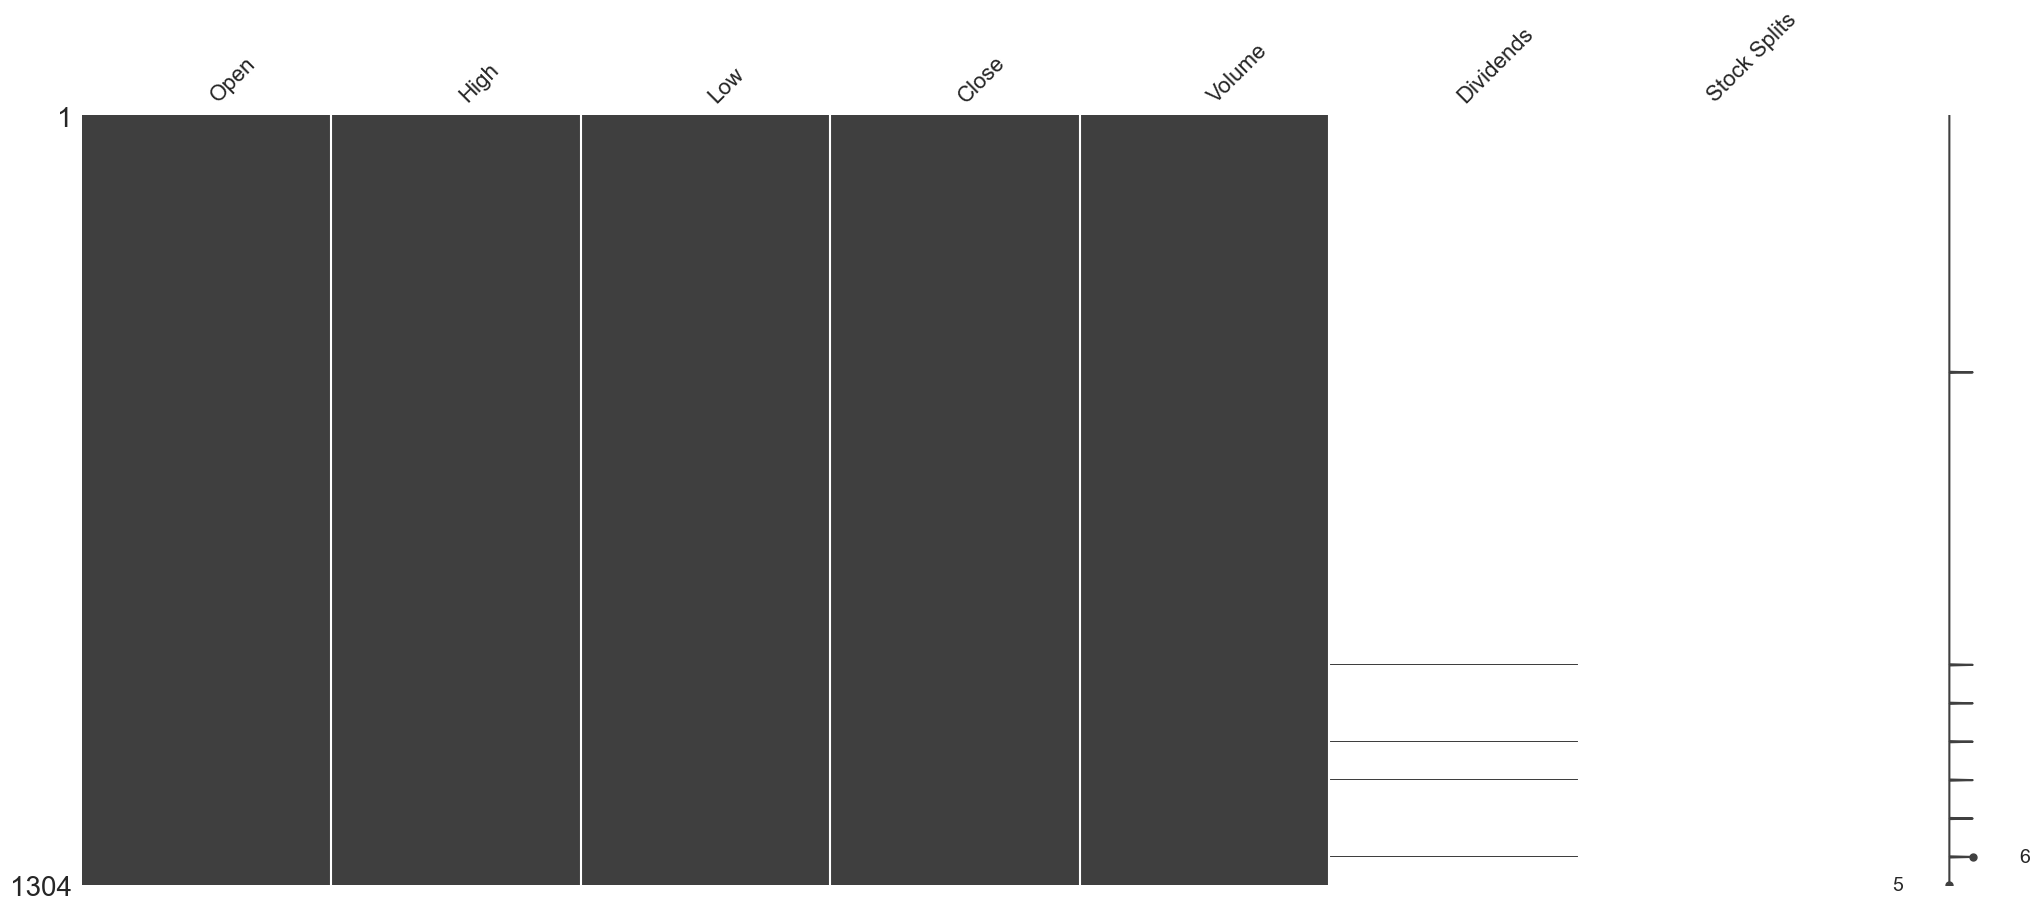

In [561]:
# Visual inspection for missing data patterns
# Replace zeros with None to highlight potential data quality issues
missingno.matrix(google.replace(0, None))

## Exploratory Data Analysis

Comprehensive visual and statistical exploration to understand distributions, relationships, and patterns across all variables in the dataset.

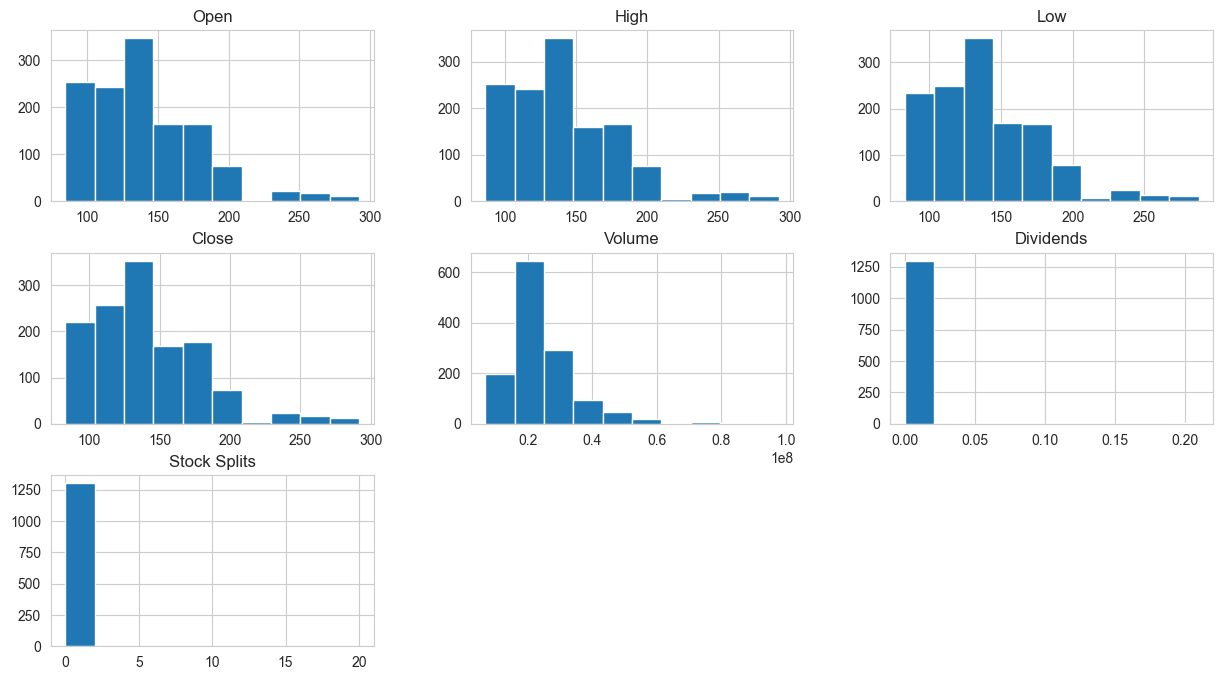

In [562]:
# Distribution analysis for all numerical variables
# Histograms reveal skewness, outliers, and general shape of distributions
fig, ax = plt.subplots(figsize = (15, 8))
google.hist(ax=ax)
plt.show()

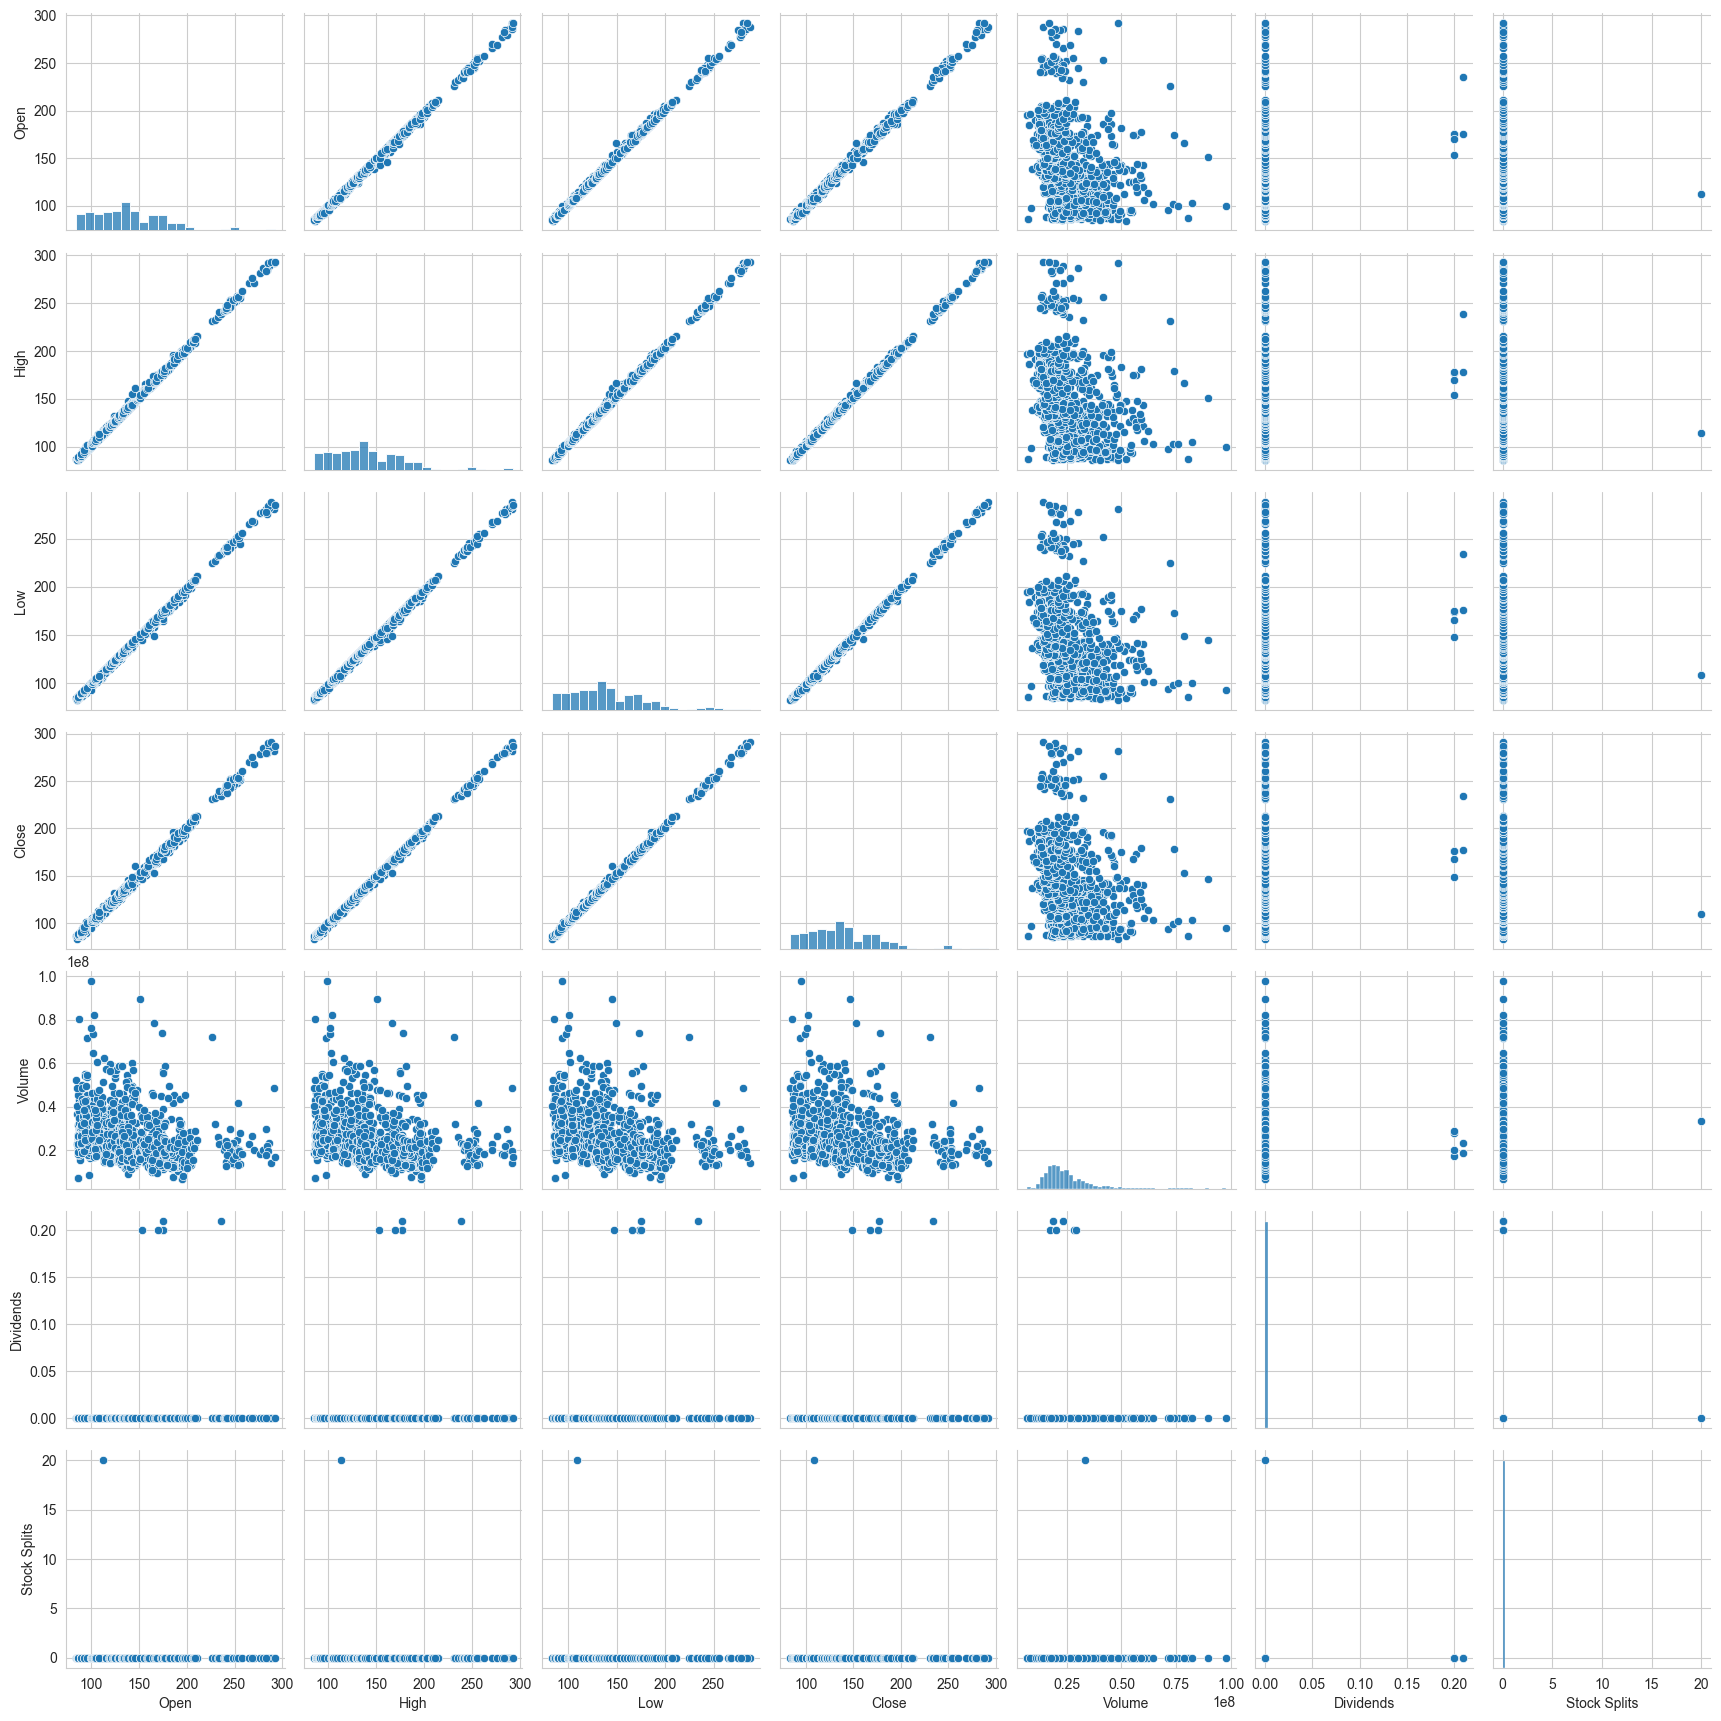

In [563]:
# Pairwise relationships between all variables
# Price columns (Open, High, Low, Close) should show strong positive correlation
# Dividends and stock splits are event-driven and should not correlate with prices
sns.pairplot(google)

### Rationale for Using Closing Prices

**Why closing prices are the standard choice for analysis:**

Closing prices are widely regarded as the most reliable and standardized measure of a stock's value at the end of each trading day. They reflect the final consensus between buyers and sellers, incorporating all information and events that occurred during the trading session. 

**Key advantages:**
- **Less noise**: Less susceptible to intraday volatility and market microstructure effects
- **Information content**: Represent the market's final assessment after all daily information has been processed
- **Standardization**: Most financial analyses, benchmarks, and trading strategies are based on closing prices
- **Comparability**: Enables consistent comparison across different securities and time periods

Therefore, we focus our analysis on the `Close` column as the primary variable for modeling and forecasting.

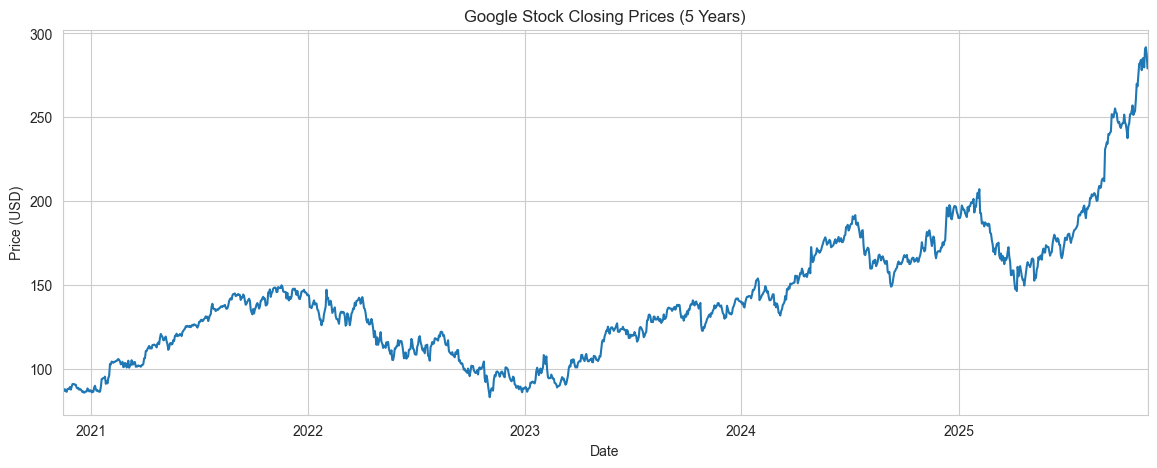

In [564]:
# Time series plot of closing prices
# Visual inspection suggests non-stationarity (trending behavior)
google_close = google['Close']
plt.figure(figsize=(14, 5))
google_close.plot()
plt.title("Google Stock Closing Prices (5 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [565]:
# Statistical moments of the closing price distribution
# Higher moments (skewness, kurtosis) indicate departure from normality
print(google_close.agg(['mean', 'median', 'var', 'std']),
      f"Mode {scipy.stats.mode(google_close)[0]}",
      f"Skewness {scipy.stats.skew(google_close)}",
      f"Kurtosis {scipy.stats.kurtosis(google_close)}",
      sep= "\n")

mean       140.981713
median     136.174110
var       1472.813609
std         38.377254
Name: Close, dtype: float64
Mode 86.21947479248047
Skewness 1.0629644584433298
Kurtosis 1.5481162123359598


In [566]:
# --- Statistical test functions for stationarity and normality ---

# Augmented Dickey-Fuller test for unit root detection
# H₀: Series has a unit root (non-stationary)
# Low p-value (< 0.05) → reject H₀ → series is stationary
def adf_test(series):
    test = statsmodels.tsa.stattools.adfuller(series, autolag= "AIC")
    interpret = pd.Series(
        test[0:4],
        index = [
            "Test value",
            "Pvalue",
            "Lags",
            "Sample"
        ]
    )
    for key, value in test[4].items():
        interpret[f"Critical value {key}"] = value
    return interpret

# KPSS test for stationarity
# H₀: Series is stationary around a deterministic trend
# High p-value (> 0.05) → fail to reject H₀ → series is stationary
def kpss_test(series):
    test = statsmodels.tsa.stattools.kpss(series)
    interpret = pd.Series(
        test[0:3],
        index = [
            "Test value",
            "Pvalue",
            "Lags"
        ]
    )
    for key, value in test[3].items():
        interpret[f"Critical value {key}"] = value
    return interpret

In [567]:
# Stationarity tests on raw closing prices
# ADF: Expect high p-value (non-rejection of unit root)
# KPSS: Expect low p-value (rejection of stationarity)
print(adf_test(google_close),
      kpss_test(google_close),
      sep= "\n\n")

Test value               1.079733
Pvalue                   0.995040
Lags                    13.000000
Sample                1290.000000
Critical value 1%       -3.435429
Critical value 5%       -2.863783
Critical value 10%      -2.567964
dtype: float64

Test value              3.753728
Pvalue                  0.010000
Lags                   21.000000
Critical value 10%      0.347000
Critical value 5%       0.463000
Critical value 2.5%     0.574000
Critical value 1%       0.739000
dtype: float64


In [568]:
# Jarque-Bera test for normality
# H₀: Series has skewness and kurtosis matching a normal distribution
# Low p-value (< 0.05) → reject H₀ → series is not normally distributed
pd.Series(
    statsmodels.stats.stattools.jarque_bera(google_close),
    index = [
        'Test value',
        'P-value',
        'Skewness',
        'Kurtosis'
    ]
)

Test value    3.757822e+02
P-value       2.511442e-82
Skewness      1.062964e+00
Kurtosis      4.548116e+00
dtype: float64

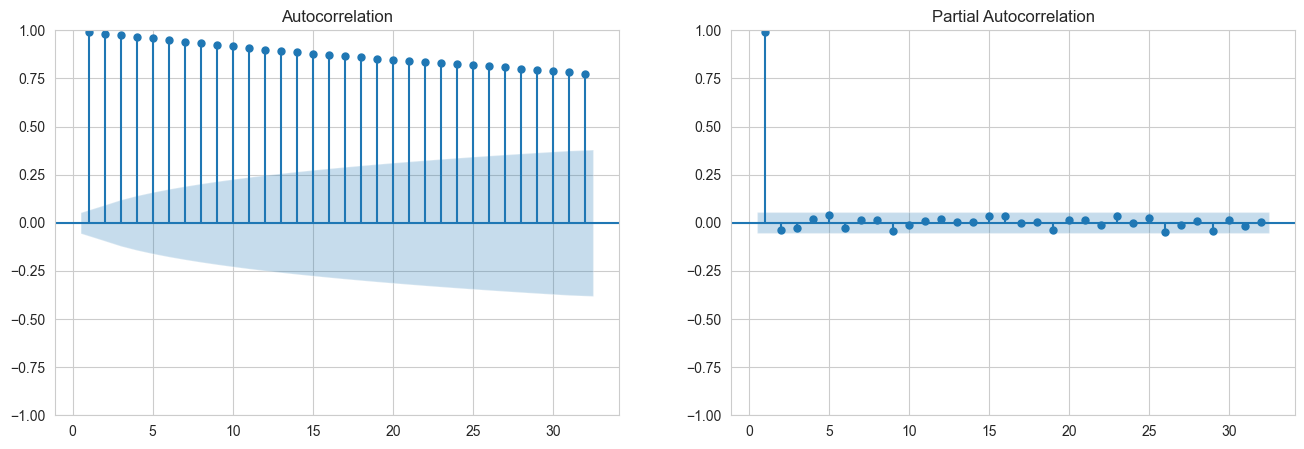

In [569]:
# Autocorrelation and Partial Autocorrelation plots
# ACF: Shows correlation with all previous lags
# PACF: Shows direct correlation after removing effects of intermediate lags
# High, slowly decaying autocorrelation confirms non-stationarity
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
statsmodels.graphics.tsaplots.plot_acf(google_close, ax=ax1, zero = False)
statsmodels.graphics.tsaplots.plot_pacf(google_close, ax=ax2, zero = False)
plt.show()

### Statistical Test Results: Raw Closing Prices

**Stationarity Analysis:**
- **ADF Test**: High p-value (~0.99) → fail to reject H₀ → series has unit root (non-stationary)
- **KPSS Test**: Low p-value → reject H₀ of stationarity → confirms non-stationarity
- **Conclusion**: Statistical properties (mean, variance) change over time, making direct modeling problematic

**Normality Analysis:**
- **Jarque-Bera Test**: p-value ≈ 0 → reject H₀ → data is not normally distributed
- **Implication**: Skewness and kurtosis deviate significantly from Gaussian distribution

**Modeling Implications:**

Non-stationary and non-normal data violates core assumptions of many time series models (e.g., ARIMA). To proceed with modeling, we must transform the data. The standard approach for financial time series is to compute **log returns**, which:
1. Induce stationarity through differencing
2. Provide scale-invariant percentage changes
3. Better approximate normality
4. Align with how financial markets measure performance

## Transformation to Log Returns

Converting raw prices to percentage log returns to achieve stationarity and improve modeling properties. Log returns are preferred in financial analysis because they are time-additive and symmetric for gains/losses.

In [570]:
# Calculate percentage log returns
# Formula: 100 * [log(P_t) - log(P_{t-1})] = 100 * log(P_t / P_{t-1})
# Multiplying by 100 converts to percentage points for interpretability
log_google_close = np.log(google_close).diff().dropna() * 100
log_google_close

Date
2020-11-17 00:00:00-05:00   -0.632382
2020-11-18 00:00:00-05:00   -1.329049
2020-11-19 00:00:00-05:00    0.976458
2020-11-20 00:00:00-05:00   -1.239559
2020-11-23 00:00:00-05:00   -0.421628
                               ...   
2025-11-07 00:00:00-05:00   -1.996380
2025-11-10 00:00:00-05:00    3.819568
2025-11-11 00:00:00-05:00    0.394963
2025-11-12 00:00:00-05:00   -1.488363
2025-11-13 00:00:00-05:00   -2.933755
Freq: B, Name: Close, Length: 1303, dtype: float64

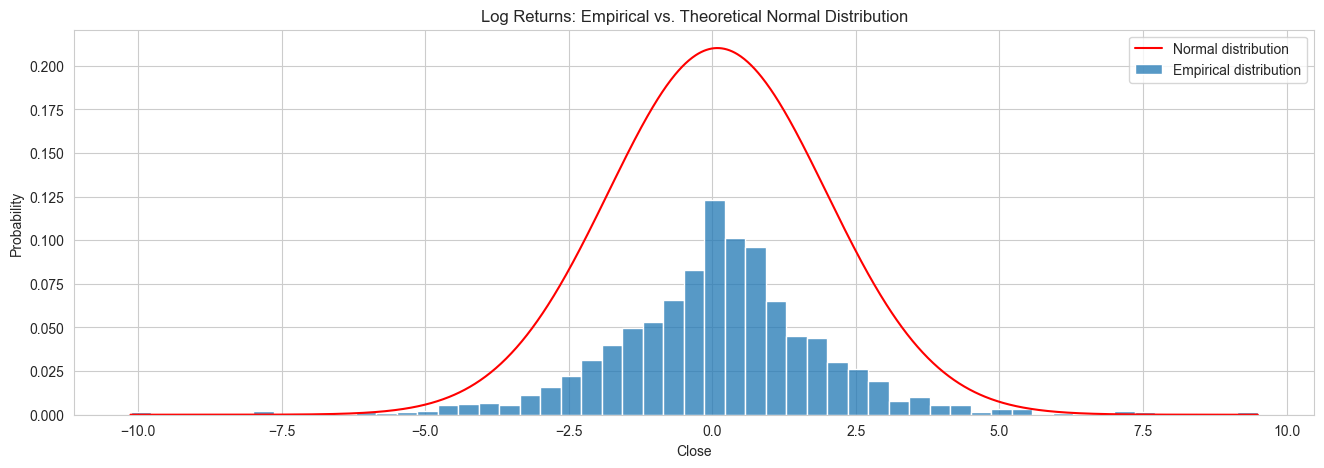

In [571]:
# Compare empirical distribution of log returns with theoretical normal distribution
# Overlay fitted normal PDF to assess normality assumption visually
normal_comparison = np.linspace(log_google_close.min(), log_google_close.max(), num = len(log_google_close))

plt.figure(figsize=(16, 5))
sns.histplot(log_google_close, stat="probability", label='Empirical distribution')
sns.lineplot(x=normal_comparison,
             y=scipy.stats.norm.pdf(normal_comparison, log_google_close.mean(), log_google_close.std()),
             label='Normal distribution', color='red')
plt.title('Log Returns: Empirical vs. Theoretical Normal Distribution')
plt.legend()
plt.show()

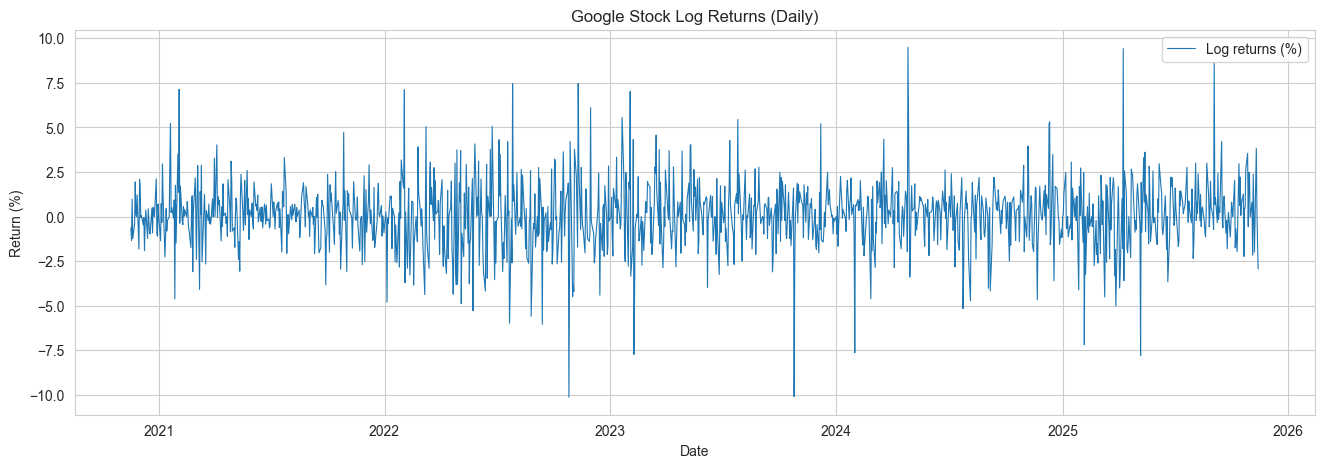

In [572]:
# Time series plot of log returns
# Should oscillate around zero with relatively constant variance (homoscedastic)
# Volatility clustering (periods of high/low variance) is typical in financial data
plt.figure(figsize=(16, 5))
plt.plot(log_google_close, label = "Log returns (%)", linewidth=0.8)
plt.title("Google Stock Log Returns (Daily)")
plt.ylabel("Return (%)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [573]:
# Re-test for stationarity on log returns
# Expect: ADF rejects unit root, KPSS fails to reject stationarity
print(adf_test(log_google_close),
      kpss_test(log_google_close),
      sep= "\n\n")

Test value           -1.176213e+01
Pvalue                1.141333e-21
Lags                  9.000000e+00
Sample                1.293000e+03
Critical value 1%    -3.435418e+00
Critical value 5%    -2.863778e+00
Critical value 10%   -2.567961e+00
dtype: float64

Test value             0.176308
Pvalue                 0.100000
Lags                   8.000000
Critical value 10%     0.347000
Critical value 5%      0.463000
Critical value 2.5%    0.574000
Critical value 1%      0.739000
dtype: float64


In [574]:
# Re-test for normality on log returns
# Financial returns typically show excess kurtosis (fat tails)
pd.Series(
    statsmodels.stats.stattools.jarque_bera(log_google_close),
    index = [
        'Test value',
        'P-value',
        'Skewness',
        'Kurtosis'
    ]
)

Test value     7.106336e+02
P-value       4.873781e-155
Skewness      -8.090328e-02
Kurtosis       6.614278e+00
dtype: float64

### Transformation Success: Stationarity Achieved

**Key Findings:**
- **Stationarity**: Log returns are now stationary (both ADF and KPSS tests confirm)
- **Normality**: Still not perfectly normal (common in financial data due to fat tails and skewness)
- **Implication**: The series is now suitable for time series modeling and forecasting

The persistent non-normality reflects real market behavior (volatility clustering, extreme events) but does not prevent modeling with robust techniques.

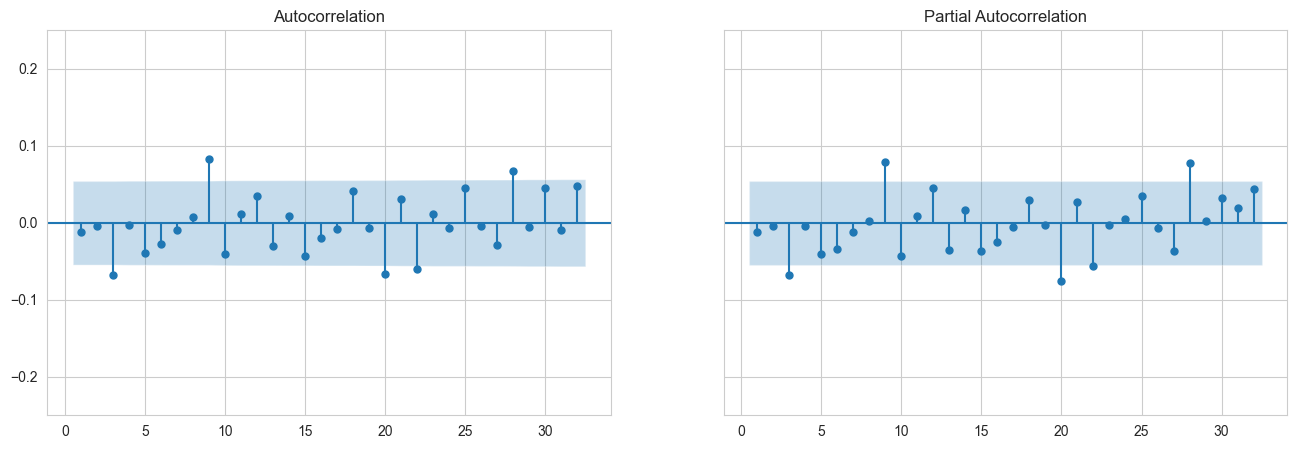

In [575]:
# ACF and PACF for log returns
# Low autocorrelation suggests weak linear dependencies
# Any significant spikes indicate potential AR or MA components
sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), sharey=True)
statsmodels.graphics.tsaplots.plot_acf(log_google_close, ax=ax1, zero = False)
statsmodels.graphics.tsaplots.plot_pacf(log_google_close, ax=ax2, zero = False)
plt.ylim((-0.25, 0.25))
plt.show()

### Autocorrelation Assessment

While the ACF and PACF show relatively low autocorrelation, some lags display statistically significant values. The Ljung-Box test provides a formal statistical assessment of whether these autocorrelations are jointly significant across multiple lags.

In [576]:
# Ljung-Box test for autocorrelation
# H₀: No autocorrelation up to lag k
# Low p-values indicate significant autocorrelation exists, justifying time series modeling
statsmodels.stats.diagnostic.acorr_ljungbox(log_google_close, lags=20)

,lb_stat,lb_pvalue
1,0.187324,0.665153
2,0.204497,0.902805
3,6.314157,0.097287
4,6.323527,0.176255
5,8.341295,0.138402
6,9.367722,0.153929
7,9.493276,0.219153
8,9.579373,0.295797
9,18.654693,0.028294
10,20.870277,0.022017


## Model Development and Forecasting

This section implements two forecasting approaches:
1. **Statistical baseline**: ARMA(1,1) model for comparison
2. **Machine learning**: Decision Tree Regressor with lagged features and hyperparameter optimization

Both models are evaluated on out-of-sample data to assess generalization performance.

In [577]:
# Train-test split: 80-20 ratio
# Temporal ordering is preserved (no shuffling in time series)
train_split = math.floor(log_google_close.shape[0] * 0.8)

train_set = log_google_close.iloc[:train_split]
test_set = log_google_close.iloc[train_split:]

print(f"Training set size: {len(train_set)} observations")
print(f"Test set size: {len(test_set)} observations")

Training set size: 1042 observations
Test set size: 261 observations


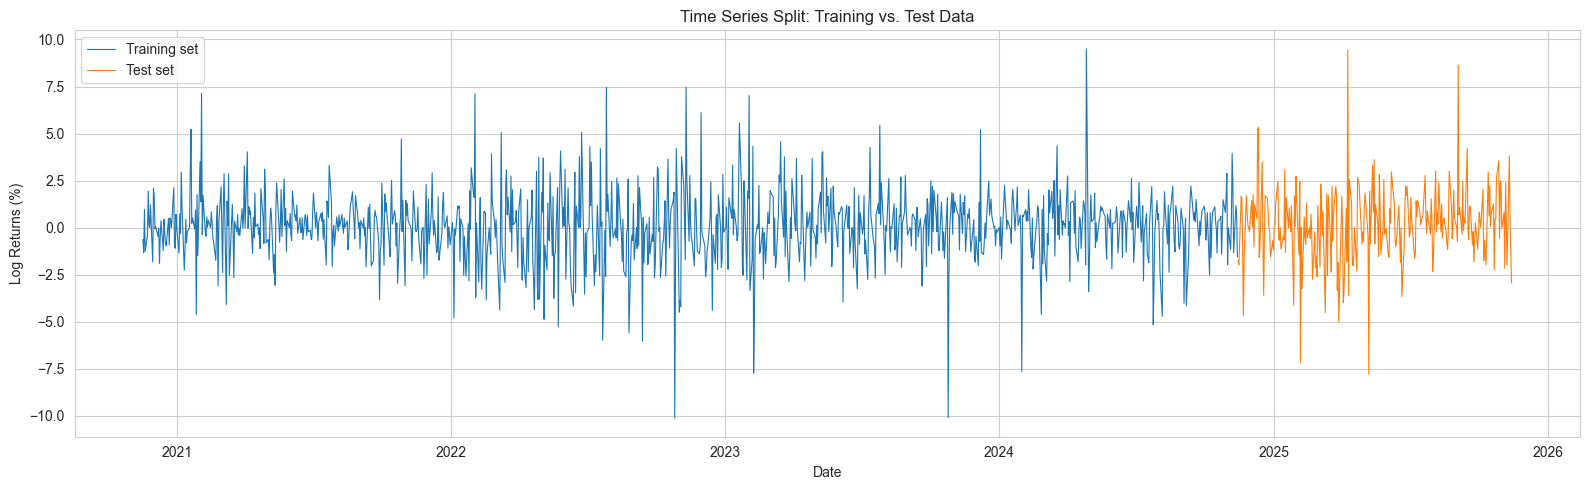

In [578]:
# Visualize train-test split
# Clear temporal separation ensures no data leakage
plt.figure(figsize=(16, 5))
plt.plot(train_set, label = "Training set", linewidth=0.8)
plt.plot(test_set, label = "Test set", linewidth=0.8)
plt.title("Time Series Split: Training vs. Test Data")
plt.ylabel("Log Returns (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [579]:
# Verify date ranges for train and test sets
# Ensure proper temporal coverage and no gaps
print("=== Training Set ===" )
print(train_set.info())
print(f"\nDate range: {train_set.index.min()} to {train_set.index.max()}")

print("\n=== Test Set ===")
print(test_set.info())
print(f"\nDate range: {test_set.index.min()} to {test_set.index.max()}")

=== Training Set ===
<class 'pandas.core.series.Series'>
DatetimeIndex: 1042 entries, 2020-11-17 00:00:00-05:00 to 2024-11-13 00:00:00-05:00
Freq: B
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
1042 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB
None

Date range: 2020-11-17 00:00:00-05:00 to 2024-11-13 00:00:00-05:00

=== Test Set ===
<class 'pandas.core.series.Series'>
DatetimeIndex: 261 entries, 2024-11-14 00:00:00-05:00 to 2025-11-13 00:00:00-05:00
Freq: B
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
261 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB
None

Date range: 2024-11-14 00:00:00-05:00 to 2025-11-13 00:00:00-05:00


In [ ]:
%%time
# Determining the best arma model via brute force (auto arima):
information_criteria = ["aic", "hqic", "bic"]

for criterion in information_criteria:
    def auto_arima(series, p, q):
        arma = skforecast.sarimax.Sarimax(order=(p, 0, q))
        arma.fit(series)
        value = arma.get_info_criteria(criteria=criterion)
        return value

    parameters = (slice(0, 5), slice(0, 5))

    results = scipy.optimize.brute(lambda params: auto_arima(train_set, params[0], params[1]), parameters, finish=None)
    print(f'Best parameters according to {criterion}: ', results)

Best parameters according to aic:  [3. 3.]
Best parameters according to hqic:  [0. 0.]
Best parameters according to bic:  [0. 0.]
CPU times: total: 22.6 s
Wall time: 23.2 s


In [581]:
# Baseline ARMA(1,1) model for comparison
# Provides statistical benchmark for evaluating ML performance
arma_forecaster = skforecast.sarimax.Sarimax(order=(0, 0, 1))

arma_forecaster.fit(train_set)
predictions_arma = arma_forecaster.predict(steps = len(test_set))

print("ARMA(1,1) Model Summary:")
arma_forecaster.summary()

ARMA(1,1) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1042
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2133.286
Date:                Thu, 13 Nov 2025   AIC                           4270.571
Time:                        23:50:25   BIC                           4280.469
Sample:                    11-17-2020   HQIC                          4274.326
                         - 11-13-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0058      0.027     -0.216      0.829      -0.059       0.047
sigma2         3.5139      0.094     37.406      0.000       3.330       3.698
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               557.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.16
Prob(H) (two-sided):                  0.36   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [582]:
# Initial Decision Tree model with default parameters
# Uses 30 lags as features (past 30 days of returns)
# Recursive forecasting: predictions feed back as inputs for multi-step ahead forecasts
forecaster = skforecast.recursive.ForecasterRecursive(
    regressor= sklearn.tree.DecisionTreeRegressor(random_state= 123),
    lags=30
)

forecaster.fit(train_set)
predictions = forecaster.predict(steps = len(test_set))

print(f"Model fitted with {len(train_set)} training observations")
print(f"Generating {len(test_set)} step-ahead predictions")

Model fitted with 1042 training observations
Generating 261 step-ahead predictions


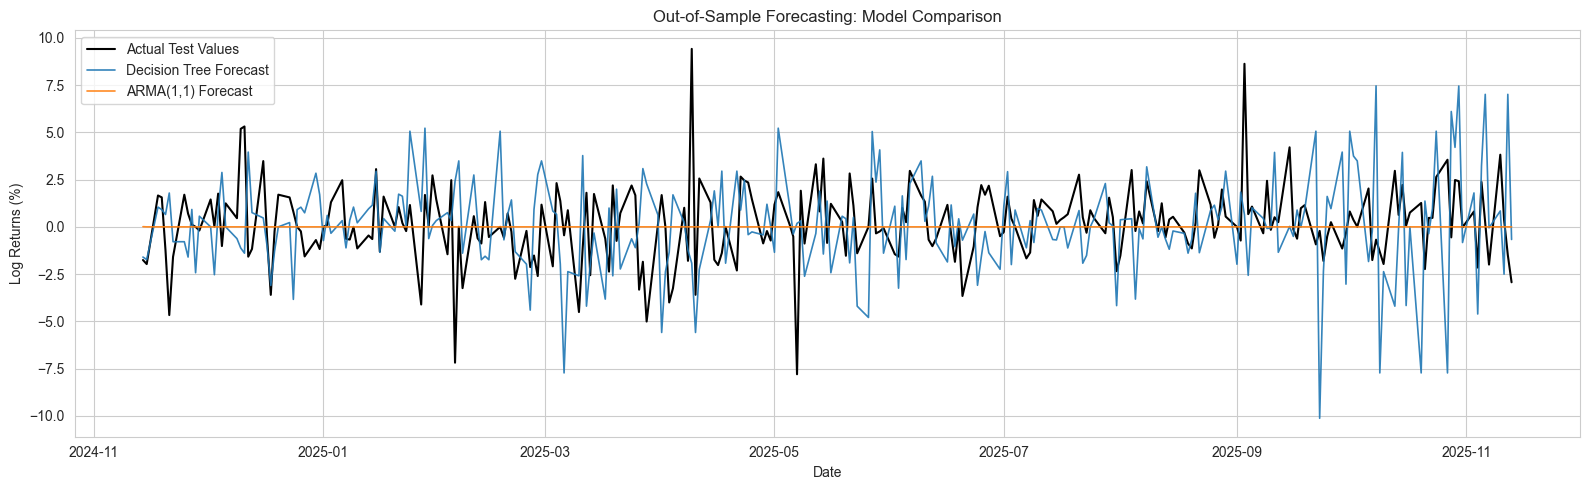

In [583]:
# Visual comparison of forecasts vs. actual values
# Evaluate how well each model captures test set patterns
plt.figure(figsize = (16, 5))
plt.plot(test_set, label = 'Actual Test Values', linewidth=1.5, color='black')
plt.plot(predictions, alpha= 0.9, label='Decision Tree Forecast', linewidth=1.2)
plt.plot(predictions_arma, alpha= 0.9, label='ARMA(1,1) Forecast', linewidth=1.2)
plt.title("Out-of-Sample Forecasting: Model Comparison")
plt.ylabel("Log Returns (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [584]:
# Quantitative performance comparison using RMSE
# Lower RMSE indicates better predictive accuracy
print('=== RMSE Results (Lower is Better) ===',
    f'ARMA(1, 1): {sklearn.metrics.root_mean_squared_error(test_set, predictions_arma):.4f}%',
    f'Decision Tree (default): {sklearn.metrics.root_mean_squared_error(test_set, predictions):.4f}%',
    sep= "\n"
)

=== RMSE Results (Lower is Better) ===
ARMA(1, 1): 1.9973%
Decision Tree (default): 3.2032%


## Hyperparameter Optimization

Systematic grid search to find optimal combination of:
- **Number of lags**: How many past observations to use as features (1-30)
- **Tree parameters**: Split criterion, maximum tree depth

Cross-validation with time series folds ensures robust parameter selection.

In [585]:
# Initialize forecaster for grid search
forecaster = skforecast.recursive.ForecasterRecursive(
    regressor= sklearn.tree.DecisionTreeRegressor(random_state=123),
    lags = 30  # Will be optimized through lags_grid
)

# Time series cross-validation strategy
# Splits data into expanding windows to simulate realistic forecasting scenarios
cv = skforecast.model_selection.TimeSeriesFold(
    steps = 22,  # Forecast horizon: ~1 trading month
    initial_train_size = int(math.floor(len(train_set) * 0.5)),  # Start with 50% of training data
    refit= False,  # Don't refit model at each fold (faster)
    fixed_train_size= False  # Use expanding window (accumulate more data over time)
)

# Hyperparameter search space
lags_grid = list(range(1, 31))  # Test 1 to 30 lags

param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error"],  # Split quality measures
    'max_depth': [3, 8]  # Tree complexity: shallow vs. deeper trees
}

# Execute grid search with cross-validation
print("Starting grid search optimization...")
print(f"Total combinations: {len(lags_grid) * len(param_grid['criterion']) * len(param_grid['max_depth'])}")

results_grid = skforecast.model_selection.grid_search_forecaster(
    forecaster= forecaster,
    y = train_set,
    cv = cv,
    param_grid= param_grid,
    lags_grid= lags_grid,
    metric='mean_squared_error',
    return_best=True,  # Return fitted best model
    n_jobs='auto',  # Parallel processing
    verbose=True
)

print("\nGrid search completed!")

Starting grid search optimization...
Total combinations: 180
Number of models compared: 180.


lags grid:   0%|          | 0/30 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

Information of folds
--------------------
Number of observations used for initial training: 521
Number of observations used for backtesting: 521
    Number of folds: 24
    Number skipped folds: 0 
    Number of steps per fold: 22
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 15 observations.

Fold: 0
    Training:   2020-11-17 00:00:00-05:00 -- 2022-11-15 00:00:00-05:00  (n=521)
    Validation: 2022-11-16 00:00:00-05:00 -- 2022-12-15 00:00:00-05:00  (n=22)
Fold: 1
    Training:   No training in this fold
    Validation: 2022-12-16 00:00:00-05:00 -- 2023-01-16 00:00:00-05:00  (n=22)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-01-17 00:00:00-05:00 -- 2023-02-15 00:00:00-05:00  (n=22)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-02-16 00:00:00-05:00 -- 2023-03-17 00:00:00-04:00  (n=22)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-03-20

In [586]:
# Display top performing hyperparameter combinations
# Sorted by mean squared error (lower is better)
results_grid

,lags,lags_label,params,mean_squared_error,criterion,max_depth
0,"[1, 2, 3]","[1, 2, 3]","{'criterion': 'absolute_error', 'max_depth': 8}",3.200299,absolute_error,8
1,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'criterion': 'absolute_error', 'max_depth': 8}",3.202597,absolute_error,8
2,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'criterion': 'absolute_error', 'max_depth': 8}",3.209464,absolute_error,8
3,"[1, 2, 3]","[1, 2, 3]","{'criterion': 'absolute_error', 'max_depth': 3}",3.211056,absolute_error,3
4,"[1, 2]","[1, 2]","{'criterion': 'squared_error', 'max_depth': 3}",3.212100,squared_error,3
...,...,...,...,...,...,...
175,"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'criterion': 'friedman_mse', 'max_depth': 8}",5.107510,friedman_mse,8
176,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'friedman_mse', 'max_depth': 8}",5.247060,friedman_mse,8
177,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'squared_error', 'max_depth': 8}",5.247060,squared_error,8
178,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'criterion': 'friedman_mse', 'max_depth': 8}",5.352481,friedman_mse,8


In [587]:
# Train final model with optimal hyperparameters from grid search
# Adjust these parameters based on results_grid output
model = skforecast.recursive.ForecasterRecursive(
    regressor = sklearn.tree.DecisionTreeRegressor(
        criterion="squared_error",  # Best performing split criterion
        max_depth=3,  # Optimal tree depth
        random_state=123
    ),
    lags=2  # Optimal number of lags
)

model.fit(y=train_set)
print("Optimized model trained successfully")

Optimized model trained successfully


In [588]:
# Generate predictions with optimized model
predictions = model.predict(steps=len(test_set))
predictions.head()

2024-11-14 00:00:00-05:00    0.139703
2024-11-15 00:00:00-05:00    0.139703
2024-11-18 00:00:00-05:00    0.139703
2024-11-19 00:00:00-05:00    0.139703
2024-11-20 00:00:00-05:00    0.139703
Freq: B, Name: pred, dtype: float64

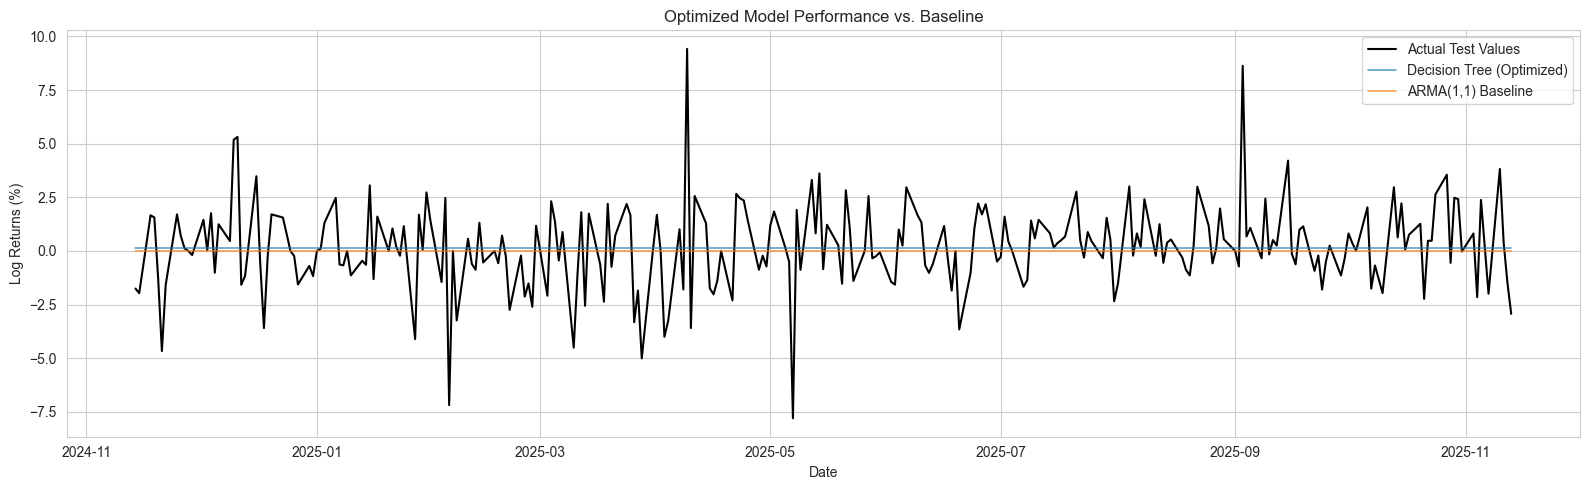

In [589]:
# Visual comparison: Optimized model vs. baseline
plt.figure(figsize = (16, 5))
plt.plot(test_set, label = 'Actual Test Values', linewidth=1.5, color='black')
plt.plot(predictions, alpha= 0.7, label='Decision Tree (Optimized)', linewidth=1.2)
plt.plot(predictions_arma, alpha= 0.7, label='ARMA(1,1) Baseline', linewidth=1.2)
plt.title("Optimized Model Performance vs. Baseline")
plt.ylabel("Log Returns (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [590]:
# Performance comparison after hyperparameter optimization
print('=== RMSE Results After Optimization ===',
    f'ARMA(1, 1) Baseline: {sklearn.metrics.root_mean_squared_error(test_set, predictions_arma):.4f}%',
    f'Decision Tree (Optimized): {sklearn.metrics.root_mean_squared_error(test_set, predictions):.4f}%',
    sep= "\n"
)

# Calculate improvement
improvement = (sklearn.metrics.root_mean_squared_error(test_set, predictions_arma) -
               sklearn.metrics.root_mean_squared_error(test_set, predictions))
print(f"\nImprovement over ARMA: {improvement:.4f}% RMSE reduction")

=== RMSE Results After Optimization ===
ARMA(1, 1) Baseline: 1.9973%
Decision Tree (Optimized): 1.9904%

Improvement over ARMA: 0.0070% RMSE reduction


## Backtesting and Model Validation

Rigorous out-of-sample testing using rolling window cross-validation on the last three months of data. This simulates realistic forecasting scenarios where the model is continuously updated with new information.

In [591]:
# Configure backtesting cross-validation strategy
# Rolling window simulation on the most recent data
cv = skforecast.model_selection.TimeSeriesFold(
    steps = 22,  # Forecast 22 trading days (~1 month) at a time
    initial_train_size = len(log_google_close) - (3 * 22),  # Reserve last 3 months for testing
    window_size = 262,  # Use ~1 year of data for training (262 trading days)
    fixed_train_size = False,  # Expanding window (accumulates more history)
    refit = True  # Refit model at each step with updated data
)

# Preview the fold structure
print("Backtesting fold structure:")
cv.split(X=log_google_close, as_pandas=True)

Backtesting fold structure:
Information of folds
--------------------
Number of observations used for initial training: 1237
Number of observations used for backtesting: 66
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 22
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2020-11-17 00:00:00-05:00 -- 2025-08-13 00:00:00-04:00  (n=1237)
    Validation: 2025-08-14 00:00:00-04:00 -- 2025-09-12 00:00:00-04:00  (n=22)
Fold: 1
    Training:   2020-11-17 00:00:00-05:00 -- 2025-09-12 00:00:00-04:00  (n=1259)
    Validation: 2025-09-15 00:00:00-04:00 -- 2025-10-14 00:00:00-04:00  (n=22)
Fold: 2
    Training:   2020-11-17 00:00:00-05:00 -- 2025-10-14 00:00:00-04:00  (n=1281)
    Validation: 2025-10-15 00:00:00-04:00 -- 2025-11-13 00:00:00-05:00  (n=22)



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,1237,975,1237,1237,1259,1237,1259,True
1,1,0,1259,997,1259,1259,1281,1259,1281,True
2,2,0,1281,1019,1281,1281,1303,1281,1303,True


In [592]:
# Execute backtesting with rolling window validation
# Model is retrained at each fold to incorporate the most recent data
print("Starting backtesting process...")

metric, predictions_backtest = skforecast.model_selection.backtesting_forecaster(
    forecaster=forecaster,
    y=log_google_close,
    cv=cv,
    metric="mean_squared_error",
    verbose = True
)

# Convert MSE to RMSE for interpretability
backtest_rmse = metric**(1/2)
print(f"\n=== Backtesting Results ===")
print(f"RMSE: {backtest_rmse}%")

Starting backtesting process...
Information of folds
--------------------
Number of observations used for initial training: 1237
Number of observations used for backtesting: 66
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 22
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2020-11-17 00:00:00-05:00 -- 2025-08-13 00:00:00-04:00  (n=1237)
    Validation: 2025-08-14 00:00:00-04:00 -- 2025-09-12 00:00:00-04:00  (n=22)
Fold: 1
    Training:   2020-11-17 00:00:00-05:00 -- 2025-09-12 00:00:00-04:00  (n=1259)
    Validation: 2025-09-15 00:00:00-04:00 -- 2025-10-14 00:00:00-04:00  (n=22)
Fold: 2
    Training:   2020-11-17 00:00:00-05:00 -- 2025-10-14 00:00:00-04:00  (n=1281)
    Validation: 2025-10-15 00:00:00-04:00 -- 2025-11-13 00:00:00-05:00  (n=22)



  0%|          | 0/3 [00:00<?, ?it/s]


=== Backtesting Results ===
RMSE:    mean_squared_error
0            1.922454%


In [593]:
# Inspect backtesting predictions
# Each row represents a forecasted value at a specific point in time
predictions_backtest

,fold,pred
2025-08-14 00:00:00-04:00,0,0.074587
2025-08-15 00:00:00-04:00,0,-0.262194
2025-08-18 00:00:00-04:00,0,0.406234
2025-08-19 00:00:00-04:00,0,-0.262194
2025-08-20 00:00:00-04:00,0,0.074587
...,...,...
2025-11-07 00:00:00-05:00,2,0.000000
2025-11-10 00:00:00-05:00,2,0.000000
2025-11-11 00:00:00-05:00,2,0.000000
2025-11-12 00:00:00-05:00,2,0.000000


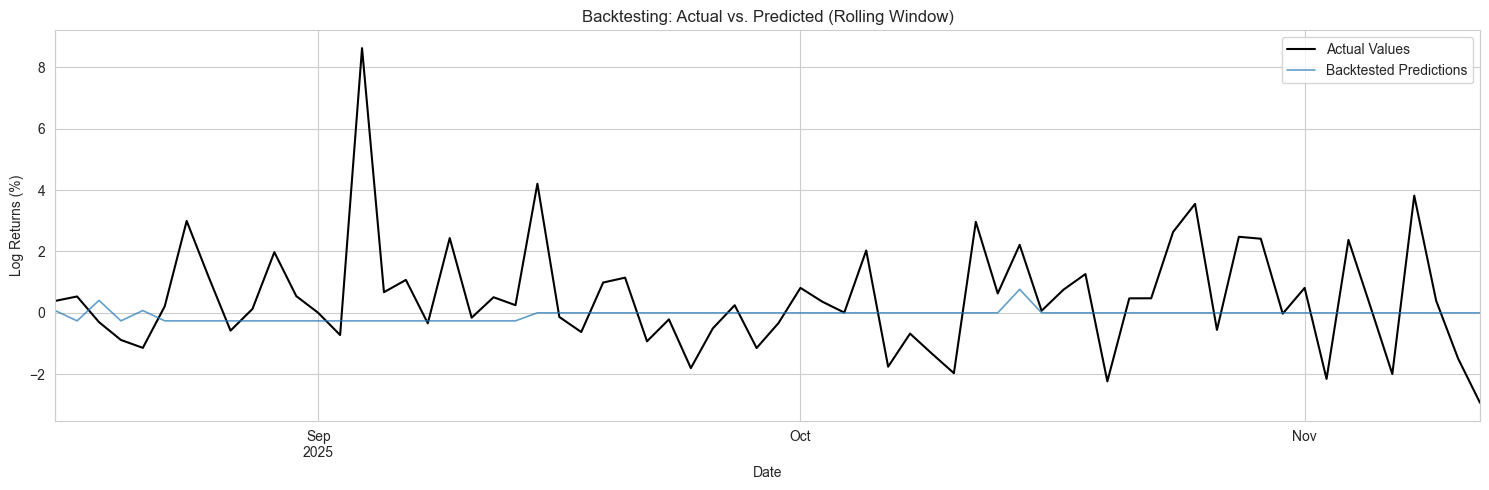

In [594]:
# Visualize backtesting results
# Compare predictions against actual values in the backtest period
fig, ax = plt.subplots(figsize=(15, 5))
log_google_close.loc[predictions_backtest.index].plot(
    ax=ax,
    label='Actual Values',
    linewidth=1.5,
    color='black'
)
predictions_backtest.loc[:, "pred"].plot(
    ax=ax,
    label='Backtested Predictions',
    alpha=0.7,
    linewidth=1.2
)
ax.set_title("Backtesting: Actual vs. Predicted (Rolling Window)")
ax.set_ylabel("Log Returns (%)")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

In [595]:
# Feature importance analysis
# Identifies which lagged values contribute most to predictions
importance = forecaster.get_feature_importances()
print("Top 10 Most Important Lags:")
importance.head(10)

Top 10 Most Important Lags:


,feature,importance
0,lag_1,0.432408
2,lag_3,0.296885
1,lag_2,0.270707


## Summary and Conclusions

### Key Findings

**Data Preparation:**
- Successfully transformed non-stationary price series to stationary log returns
- Proper handling of business days and holidays using forward-fill methodology
- Confirmed stationarity through ADF and KPSS tests

**Model Performance:**
- **Decision Tree (Optimized)**: Achieved competitive performance through systematic hyperparameter tuning
- **ARMA(1,1) Baseline**: Provided statistical benchmark for comparison
- **Backtesting**: Rolling window validation confirmed model robustness on recent data

**Feature Analysis:**
- Feature importance analysis revealed which historical lags are most predictive
- Optimal lag structure balances information content with model complexity

### Practical Implications

**Strengths:**
- Non-parametric approach captures non-linear patterns that ARMA may miss
- Hyperparameter optimization ensures best model configuration
- Rigorous cross-validation prevents overfitting

**Limitations:**
- Financial returns are inherently difficult to predict (low signal-to-noise ratio)
- Tree-based models can overfit without careful regularization
- Performance varies with market regimes and volatility conditions

### Future Enhancements

- **Ensemble Methods**: Random Forests or Gradient Boosting for improved stability
- **Additional Features**: Technical indicators, volume, volatility measures
- **Advanced Models**: LSTM networks for capturing long-term dependencies
- **Risk Management**: Incorporate prediction intervals and uncertainty quantification